<a href="https://colab.research.google.com/github/JavierMoralesEstevez/Pix2Pix-para-Audios/blob/master/pix2pix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Presentación
Hola DotCSV e interesados en el machine learning, Os presento mi implementación del algoritmo **pix2pix**.

En mi caso lo he rebautizado como **voice2voice**, ya que utilizo audios en lugar de imágenes, audios que transformo a imágenes para posteriormente procesarlas en la red neuronal pix2pix.

Tengo que decir que me he topado con varios problemas. Ya que los audios "Target" pueden ocupar más bytes que los de una imagen de 256x256 pixels, aún teniendo en cuenta los tres canales de color, he tenido que intentar bajar la calidad de los audios, sin resultados cualitativos y finalmente utilizar imágenes de 512x512 pixels. Con todo lo que conlleva, más procesamiento y como se me hacía tarde para la entrega, procesamiento en la nube de Google Cloud (sponsor) con una tarjeta Nvidia Tesla P100.



In [98]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Para el procesamiento en la nube, tuve de comentar esta línea:

In [0]:
%tensorflow_version 2.x

Definimos los imports y las rutas.

Para crear los inputs me descargué el videotutorial de DotCSV sobre la implementación de pix2pix, en forma de audio. Conjuntamente con la transcripción de youtube.

Utilicé ffmpeg para, con el tiempo de las frases, recortar los audios en trozos mas pequeños. También generé esa misma frase con google translate y me descargué el audio. Dejo una pequeña aplicación en php para la descarga de los audios de google translate.

La transcripción de youtube podría haber sido mejor, pero no pensé opciones en ese momento. También hice una criba de los archivos de mayor tamaño.

Trabajaremos con una versión de archivos más reducida que la producida originalmente.

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# ruta raiz
PATH = "/content/drive/My Drive/"
#PATH = "Voices/"

# ruta de datos de entrada
INaudio =  PATH + "inputVoices/"
TARaudio =  PATH + "targetVoices/"
# ruta de datos de salida
OUTaudio =  PATH + "outputVoices/"
# ruta de los checkpoints
CKPATH = PATH + "checkpointsVoices/"

# estas carpetas contendrán los audios con la evolución
OUTaudioAux =  PATH + "outputVoicesAux/"
INaudioAux =  PATH + "inputVoicesAux/"
TARaudioAux =  PATH + "targetVoicesAux/"

INaudioJpeg =  PATH + "inputVoicesJpeg/"
TARaudioJpeg =  PATH + "targetVoicesJpeg/"
OUTaudioJpeg =  PATH + "outputVoicesJpeg/"


Leemos el directorio y guardamos los inputs en variables

In [101]:

imgurls = !ls -1 "{TARaudio}"

n = len(imgurls)

train_n = round(n * 0.80)

# listado randomizado
randurls = np.copy(imgurls)

#np.random.seed(23) # solo para el tutorial
np.random.shuffle(randurls)

# partición train/test
tr_urls = randurls[:train_n]
ts_urls = randurls[train_n:n]

print(len(imgurls), len(tr_urls), len(ts_urls))
tr_urls


2740 2192 548


array(['voice2voice_632.wav', 'voice2voice_2294.wav',
       'voice2voice_1785.wav', ..., 'voice2voice_1418.wav',
       'voice2voice_2340.wav', 'voice2voice_2277.wav'], dtype='<U20')

Seleccionamos el tamaño de las imágenes y procedemos a redimensionar el audio para que parezca una imagen.

Una imagen 256x256 pixeles en jpeg no es más que un array de 256x256x3, 3 canales de color, que por supuesto utilizo para guardar más datos del audio.
Como he comentado anteriormente utilizo tamaños de 512x512x3.

Es una lastima que tensorflow no procese imagenes .tiff, pues las necesitamos ya que el audio contiene decimales (float) y los jpeg no.

voice2voice_632.wav


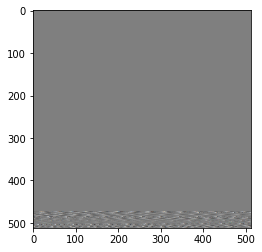

In [102]:
IMG_WIDTH = 512
IMG_HEIGHT = 512


# reescalar imagenes
def resize(inimg, tgimg, width, height):
    inimg = tf.image.resize(inimg, (width, height) )
    tgimg = tf.image.resize(tgimg, (width, height) )
    return inimg, tgimg


# reescalar imagenes
def resize1D(inimg, tgimg, width, height):
    n=width*height*3
    n1 = n - tf.shape(inimg)[0]*1
    n2 = n - tf.shape(tgimg)[0]*2
    inimg = tf.reshape(inimg, [tf.shape(inimg)[0]*tf.shape(inimg)[1],1] )
    tgimg = tf.reshape(tgimg, [tf.shape(tgimg)[0]*tf.shape(tgimg)[1],1] )
    inimg = tf.pad(inimg, ([n1,0],[0,0]), mode='CONSTANT')
    tgimg = tf.pad(tgimg, ([n2,0],[0,0]), mode='CONSTANT')
    return inimg, tgimg


#restaurar dimensiones desde 3dim a 1dim
def resize3to1(imagen, c):
    dim = tf.cast(((tf.shape(imagen)[0])*(tf.shape(imagen)[0])*3/c), tf.int32)
    imagen = tf.reshape(imagen, (dim,c) )
    #imagen = np.array(imagen)
    #imagen = imagen[~np.all(imagen == 0, axis=1)] 
    return imagen


# reescalar imagenes desde 1dim(Zx1) a 3dim
def resize1to3(inimg, tgimg):
    a = tf.cast(tf.shape(inimg)[0], tf.float32)
    b = tf.cast(tf.shape(tgimg)[0], tf.float32)
    n1 = tf.cast((tf.math.sqrt(a/3)), tf.int32)
    n2 = tf.cast((tf.math.sqrt((b*1)/3)),tf.int32)
    inimg = tf.reshape(inimg, (n1,n1,3) )
    tgimg = tf.reshape(tgimg, (n2,n2,3) )
    #inimg = np.resize(inimg, (n1,n1,3) )
    #tgimg = np.resize(tgimg, (n2,n2,3) )
    return inimg, tgimg


def normalize(inimg, tgimg):
    #inimg = inimg[:,:,-1]
    #tgimg = tgimg[:,:,-1]
    inimg = (inimg / 127.5) -1
    tgimg = (tgimg / 127.5) -1

    return inimg, tgimg


# aumentación de datos: random crop + flip
@tf.function()
def random_jitter(inimg, tgimg):
  
    inimg, tgimg = resize(inimg, tgimg, (IMG_WIDTH+20), (IMG_HEIGHT+20))
  
    stacked_image = tf.stack([inimg, tgimg], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, [2, IMG_WIDTH, IMG_HEIGHT, 3 ])
    inimg, tgimg = cropped_image[0], cropped_image[1]
  
    if np.random.uniform() > 0.5: 
        #inimg = tf.image.flip_up_down(inimg)
        #tgimg = tf.image.flip_up_down(tgimg)
        inimg = tf.image.flip_left_right(inimg)
        tgimg = tf.image.flip_left_right(tgimg)
    
    return inimg, tgimg


def save_audio(imagen, filename):
    img1 = tf.io.encode_jpeg(tf.cast(imagen, tf.uint8))
    tf.io.write_file(OUTaudioJpeg+filename+".jpeg", img1  )
    imagen = resize3to1(imagen, 2)
    imagen = tf.audio.encode_wav(imagen, 44100)
    tf.io.write_file(OUTaudio+filename, imagen)

                        
def save_audios(imagen, imagen2, filename):
    img1 = tf.io.encode_jpeg(tf.cast(imagen, tf.uint8))
    tf.io.write_file(INaudioJpeg+filename+".jpeg", img1  )
    img2 = tf.io.encode_jpeg(tf.cast(imagen2, tf.uint8))
    tf.io.write_file(TARaudioJpeg+filename+".jpeg", img2 )
    imagen = resize3to1(imagen, 1)
    imagen = tf.audio.encode_wav(imagen, 24000) 
    tf.io.write_file(INaudioAux+filename, imagen)
    imagen2 = resize3to1(imagen2, 2)
    imagen2 = tf.audio.encode_wav(imagen2, 44100) 
    tf.io.write_file(TARaudioAux+filename, imagen2)
    

#@tf.function()
def openImage(filename):

    inimg, samplerate1 = tf.audio.decode_wav(tf.io.read_file(INaudio+filename))
    tgimg, samplerate2 = tf.audio.decode_wav(tf.io.read_file(TARaudio+filename))
  
    inimg, tgimg = resize1D(inimg, tgimg, IMG_WIDTH, IMG_HEIGHT )
    inimg, tgimg = resize1to3(inimg, tgimg)
    return inimg, tgimg
  

@tf.function()
def load_image(filename, augment= True):


    #inimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(inputs+filename)), tf.float32)[...,:3]
    #tgimg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(inputs+filename)), tf.float32)[...,:3]
  
    inimg, tgimg = openImage(filename)

    if augment:
        inimg, tgimg = random_jitter(inimg, tgimg )
  
    #inimg, tgimg = normalize(inimg, tgimg)

    return inimg, tgimg



def load_train_image(filename):
    return load_image(filename, True)


def load_test_image(filename):
    return load_image(filename, False)


print(randurls[0])
#plt.imshow(load_train_image(randurls[0]))
#load_train_image(randurls[0])
plt.imshow(((load_train_image(randurls[0])[0]) + 1) / 2)


El código a continuación no cambia del original, crearemos un dataset con los datos de entrada, implementaremos las funciones necesarias para crear la red neuronal pix2pix y finalmente la entrenaremos no sin antes guardar los inputs y outputs.

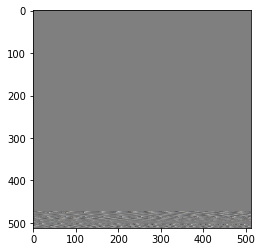

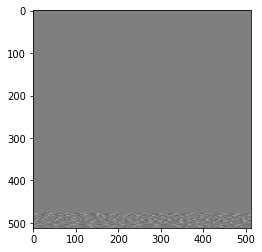

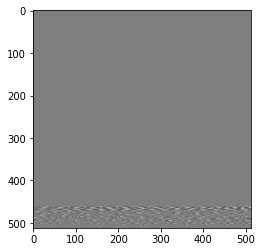

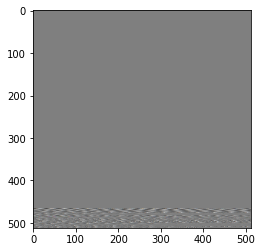

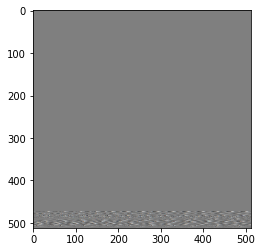

In [103]:

train_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
train_dataset = train_dataset.map(load_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(1)


test_dataset = tf.data.Dataset.from_tensor_slices(tr_urls)
test_dataset = test_dataset.map(load_test_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(1)


for inimg, tgimg in train_dataset.take(5):
    plt.imshow(((inimg[0,...]) + 1) / 2)
    plt.show()


In [104]:
from tensorflow.keras import *
from tensorflow.keras.layers import *

def downsample(filters, apply_batchnorm=True):

    result = Sequential()

    initializer = tf.random_normal_initializer(0, 0.02)

    # capa convolucional
    result.add(Conv2D(filters,
                    kernel_size=4,
                    strides=2,
                    padding="same",
                    kernel_initializer=initializer,
                    use_bias=not apply_batchnorm))
  
    if apply_batchnorm:
      # capa batchNorm.
      result.add(BatchNormalization())

    # capa de activación
    result.add(LeakyReLU())

    return result

downsample(64)

In [105]:
def upsample(filters, apply_dropout=False):

    result = Sequential()

    initializer = tf.random_normal_initializer(0, 0.02)

    # capa convolucional
    result.add(Conv2DTranspose(filters,
                            kernel_size=4,
                            strides=2,
                            padding="same",
                            kernel_initializer=initializer,
                            use_bias=False))
  
    # capa batchNorm.
    result.add(BatchNormalization())

    if apply_dropout:
      # capa de Dropout
      result.add(Dropout(0.5))

    # capa de activación
    result.add(ReLU())

    return result

upsample(64)

In [0]:
def Generator():

    inputs = tf.keras.layers.Input(shape=[None,None,3])

    down_stack = [
                downsample(64, apply_batchnorm=False), # (bs, 128, 128, 64)
                downsample(128),                        # (bs, 64,  64,  128)
                downsample(256),
                downsample(512),
                downsample(512),
                downsample(512),
                downsample(512),
                downsample(512),
    ]

    up_stack = [
              upsample(512, apply_dropout=True), # (bs, 2, 2, 1024)
              upsample(512, apply_dropout=True),
              upsample(512, apply_dropout=True),
              upsample(512),
              upsample(256),
              upsample(128),
              upsample(64),
    ]

    initializer = tf.random_normal_initializer(0, 0.02)

    last = Conv2DTranspose(filters = 3, 
                         kernel_size=4,
                         strides = 2,
                         padding = "same",
                         kernel_initializer = initializer,
                         activation = "tanh")
  
    x = inputs
    s = []

    concat = Concatenate()

    for down in down_stack:
        x = down(x)
        s.append(x)

    s = reversed(s[:-1])

    for up, sk in zip(up_stack, s):
        s
        x = up(x)
        x = concat([x, sk])

    last = last(x)

    return Model(inputs=inputs, outputs=last)

generator = Generator()
#inimg = tf.shape(tf.expand_dims(inimg, 0))
#gen_output = generator(((inimg+1)*255), training=False)
#plt.imshow(gen_output[0,...])


In [0]:
def Discriminator():

    ini = Input(shape=[None, None, 3], name="input_img")
    gen = Input(shape=[None, None, 3], name="gener_img")

    con = concatenate([ini, gen])

    initializer = tf.random_normal_initializer(0, 0.02)

    down1 =  downsample(64, apply_batchnorm=False)(con)
    down2 =  downsample(128)(down1)
    down3 =  downsample(256)(down2)
    down4 =  downsample(512)(down3)

    last = tf.keras.layers.Conv2D(filters = 1, 
                                kernel_size=4,
                                strides = 1,
                                kernel_initializer = initializer,
                                padding = "same",)(down4)
    return tf.keras.Model(inputs=[ini, gen], outputs=last)

discriminator = Discriminator()

#disc_out = discriminator([((inimg+1)*255), gen_output], training=False)
#plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap="RdBu_r")
#plt.colorbar()
#disc_out.shape

In [0]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [0]:
def discriminator_loss(disc_real_output, disc_generated_output):
    # diferencia entre los true por ser real y el detectado por el discriminador
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    # diferencia entre los false por ser generado y el detectado por el discriminador
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss


In [0]:
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):

    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # mean absolute error
    li_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * li_loss)

    return total_gen_loss


In [111]:
import os

generator_optimizer     = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_prefix = os.path.join(CKPATH, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


checkpoint.restore(tf.train.latest_checkpoint(CKPATH))
#checkpoint.restore(tf.train.latest_checkpoint(CKPATH)).assert_consumed()


En la siguiente función (generate_images) he incorporado una llamada a las funciones encargadas de guardar las imagenes y los audios de los inputs y outputs.

In [0]:
def generate_images(model, test_input, tar, save_filename=False, display_imgs=True):
  
    prediction = model(test_input, training=True)

    if save_filename:
        #tf.keras.preprocessing.image.save_img(OUTaudioAux + save_filename + ".jpg", prediction[0,...])
        save_audio(prediction[0,...], save_filename) #guarda el audio e imagen de la predicción
        save_audios(test_input[0], tar[0], save_filename) #guarda el audio e imagen de los inputs
        
    plt.figure(figsize=(10,10))
    
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ["Input image", "Ground truth", "Predicted image"]

    if display_imgs:
        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            # getting the pixel values between [0,1] to plot it.
            plt.imshow(display_list[i] * 0.5 + 0.5)
            plt.axis("off")

    plt.show()


In [0]:
@tf.function()
def train_step(input_image, target):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:

        output_image = generator(input_image, training= True)

        output_gen_discr = discriminator([output_image, input_image], training=True)

        output_trg_discr = discriminator([target, input_image], training=True)

        discr_loss= discriminator_loss(output_trg_discr, output_gen_discr)

        gen_loss = generator_loss(output_gen_discr, output_image, target)


        generator_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)

        discriminator_grads = discr_tape.gradient(discr_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(generator_grads, generator.trainable_variables))

        discriminator_optimizer.apply_gradients(zip(discriminator_grads, discriminator.trainable_variables))
    

In [0]:
from IPython.display import clear_output


def train(dataset, epochs):
    for epoch in range(epochs):

        imgi = 0
        for input_image, target in dataset:
            print("epoch " + str(epoch) + " - train: " + str(imgi) + "/" + str(len(tr_urls)))
            imgi += 1
            train_step(input_image, target)
            clear_output(wait=True)

        imgi = 0
        #clear_output(wait=True)
        for inp, tar in test_dataset.take(5):
            generate_images(generator, inp, tar, str(imgi) + "_" + str(epoch), display_imgs=True)
            imgi += 1

        # saving (checkpoint) the model every 10 epochs
        if (epoch + 1) % 2 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)


In [0]:
train(train_dataset, 200)

Para limpiar los audios necesitaremos abrirlos de nuevo y limpiar los zeros del array o tensor.

In [0]:
#Con esto abrimos un audio, lo guardamos como array y lo limpiamos de ceros.
filename = "NOMBREDELARCHIVO.wav"
audio, samplerate1 = tf.audio.decode_wav(tf.io.read_file(OUTaudio+filename))
audio = np.array(audio)
audio = audio[~np.all(audio == 0, axis=1)] 
audio = tf.audio.encode_wav(audio, 44100)
tf.io.write_file(OUTaudio+filename, audio)

POSTDATA: En la carpeta "mivoice" de github hay un programa escrito en php para descargar los targets de la red neuronal, tan solo debeis escribir el contenido de la pequeña frase en index.html y se os descargará un archivo.wav